**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [158]:
import numpy as np
import sys
import time
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

# Single fluxonia
We take parameters as in Table 1 of the paper

In [2]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [3]:
levels = 4
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)
# If you run this twice it gives an error, so this has to be fixed in the source code

In [4]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

------
f_01^A = 0.06987744707831589 GHz
f_01^B = 0.13833691129686498 GHz
------
f_12^A = 5.185077668515968 GHz
f_12^B = 4.922394350520492 GHz
------
f_23^A = 0.9905236831630564 GHz
f_23^B = 1.5308324694726387 GHz
------


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [5]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

------
|n_01^A| = 0.02530557815629673
|n_01^B| = 0.044713989127808655
------
|n_12^A| = 0.5981017837109103
|n_12^B| = 0.5862083695927301
------
|n_03^A| = 0.5856510234266186
|n_03^B| = 0.5522868863936244


We see that $n^{\alpha}_{0-1} \ll n^{\alpha}_{1-2}$ as predicted by Ficheux

In [6]:
energies_ab_bare = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_ab_bare[count] = energies_b[m] + energies_a[k]
        count += 1
label_converter = np.argsort(energies_ab_bare)

In [7]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray
) -> float:
    label = k*levels + m
    index = np.where(label_converter==label)[0][0]
    return eig_states[index] 

# Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

In [8]:
n_points = 20
levels_plot = 8
jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

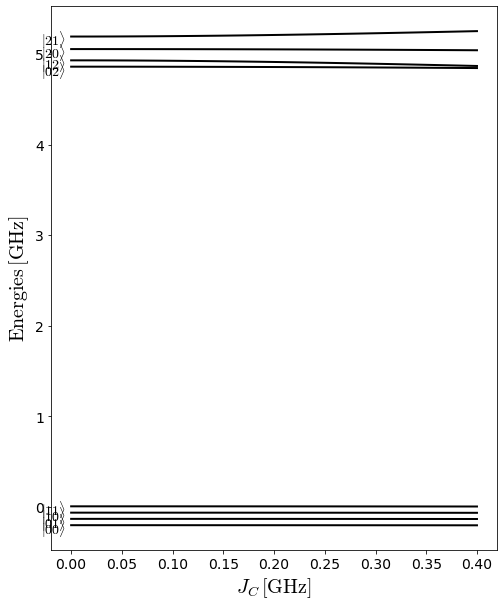

In [13]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    text_lab = ["$| 00 \\rangle $", "$| 01 \\rangle $", "$| 10 \\rangle $", "$| 11 \\rangle $", \
                "$| 02 \\rangle $", "$| 12 \\rangle $", "$| 20 \\rangle $", "$| 21 \\rangle $"]
    fig, ax = plt.subplots(figsize=(8, 10))
    for k in range(0, n_lev):
        ax.plot(jc_list, en_mat[k, :], linewidth=opt['lw'], color='black')
        plt.text(-0.03, en_mat[k, 0] - 0.1, text_lab[k], fontsize=opt['fs_text'], color='black')
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
#     ax.set_xlim([np.min(jc_list) - 0.04, np.max(jc_list)])
#     ax.set_ylim([en_mat[0, 0] - 0.5, en_mat[n_lev - 1, 0] + 0.5])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup)    

In [10]:
jc = 0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

big_delta = energies_sys[7] - energies_sys[6] + energies_sys[1] - energies_sys[3]
small_delta_opt = .29*big_delta

freq_drive_opt = energies_sys[7] - energies_sys[3] - small_delta_opt
freq_drive = freq_drive_opt

t_drive = 1/big_delta

In [11]:
print('Optimal drive frequency fd: ' + str(freq_drive) + ' [GHz]')

Optimal drive frequency fd: 5.199663485390033 [GHz]


We use the conventions of the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

According to the paper, the optimal value for $\dfrac{\delta}{\Delta}$ is $\dfrac{\delta}{\Delta} = 0.29 $

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

In [29]:
eta = [.5, .5]
n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
n_charge = [n_a, n_b]

state00 = qtp.Qobj(inpt=  label_to_states(0, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state01 = qtp.Qobj(inpt=  label_to_states(0, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state10 = qtp.Qobj(inpt=  label_to_states(1, 0, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state11 = qtp.Qobj(inpt=  label_to_states(1, 1, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])


In [15]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

Rabi period: 39.0376874795923 [ns]


#  Simulations

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [122]:
#simulation setup (noiseless)
t_points = 10000
tlist = np.linspace(0, 2*rabi_period*2*np.pi, t_points)

# state_in = qtp.Qobj(inpt=  sum(eigstates_sys[:4]), dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
state_in = state00 + state01 + state10 + state11
rho_in = state_in*state_in.dag()

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True)
pulse_drive = np.cos(freq_drive*tlist)

In [123]:
# Simulation run
result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

## Probs

In [124]:
#probabilities
state_00 = qtp.Qobj(inpt=eigstates_sys[0], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_00 = state_00*state_00.dag()
state_01 = qtp.Qobj(inpt=eigstates_sys[1], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_01 = state_01*state_01.dag()
state_10 = qtp.Qobj(inpt=eigstates_sys[2], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_10 = state_10*state_10.dag()
state_11 = qtp.Qobj(inpt=eigstates_sys[3], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_11 = state_11*state_11.dag()

state_02 = qtp.Qobj(inpt=eigstates_sys[4], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_02 = state_02*state_02.dag()
state_12 = qtp.Qobj(inpt=eigstates_sys[5], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_12 = state_12*state_12.dag()
state_20 = qtp.Qobj(inpt=eigstates_sys[6], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_20 = state_20*state_20.dag()
state_21 = qtp.Qobj(inpt=eigstates_sys[7], dims=[[levels, levels], [1, 1]], shape=[levels**2, 1])
rho_21 = state_21*state_21.dag()

probs = np.zeros([8, t_points], dtype=float)
for k in range(0, t_points):
    probs[0, k] = qtp.expect(rho_00, result.states[k]) 
    probs[1, k] = qtp.expect(rho_01, result.states[k]) 
    probs[2, k] = qtp.expect(rho_10, result.states[k]) 
    probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    probs[4, k] = qtp.expect(rho_02, result.states[k])
    probs[5, k] = qtp.expect(rho_12, result.states[k])
    probs[6, k] = qtp.expect(rho_20, result.states[k])
    probs[7, k] = qtp.expect(rho_21, result.states[k])

<IPython.core.display.Javascript object>


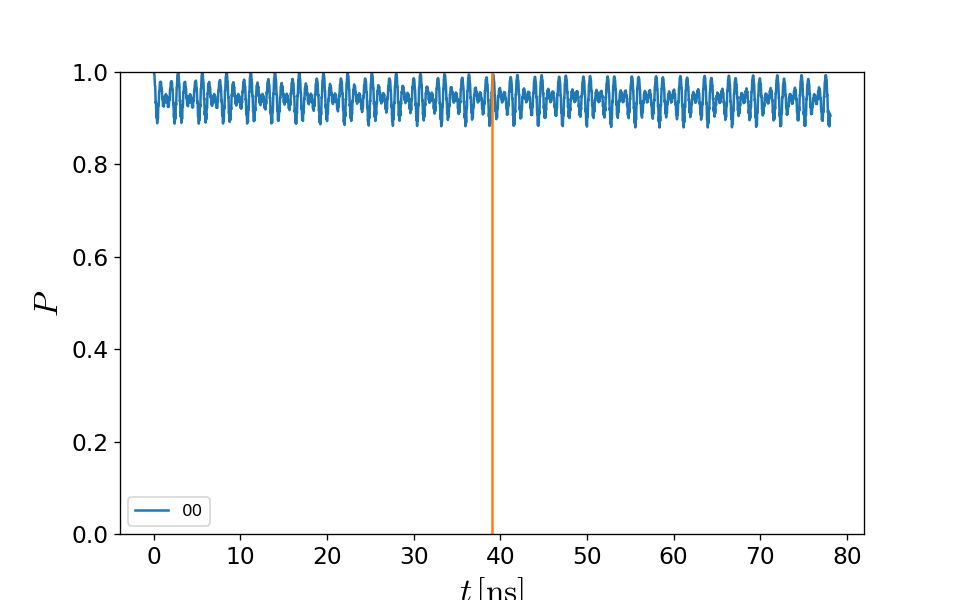

<IPython.core.display.Javascript object>


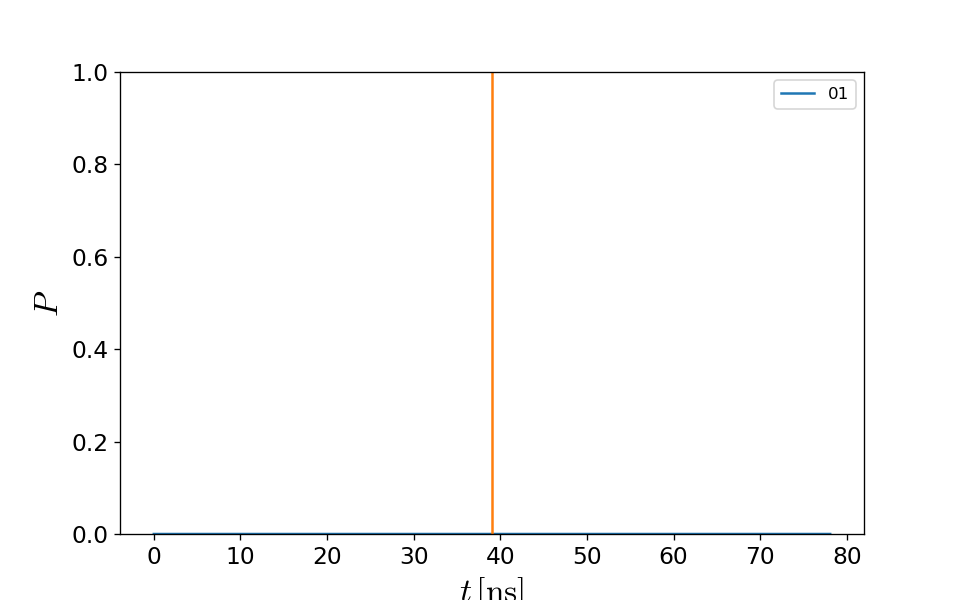

<IPython.core.display.Javascript object>


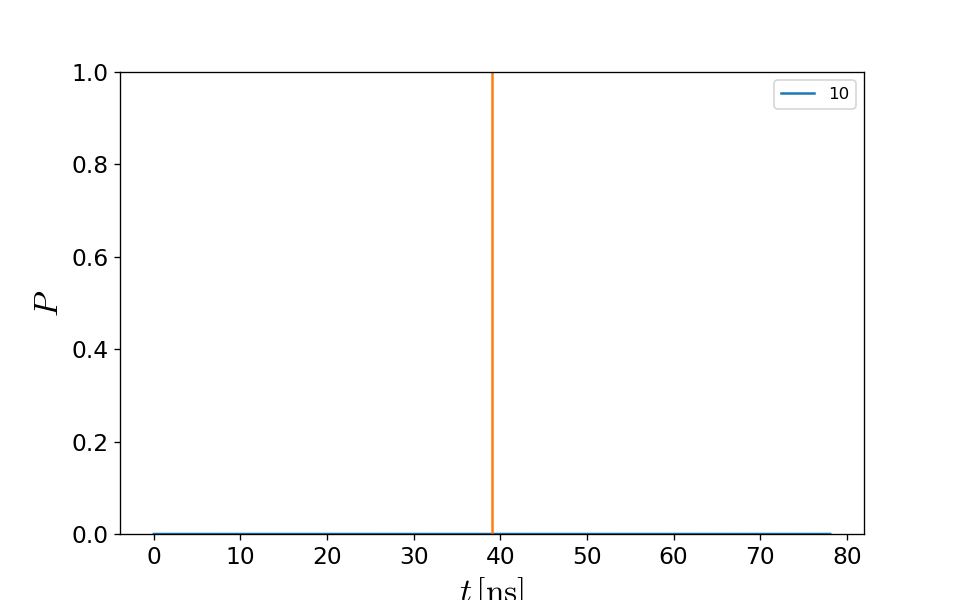

<IPython.core.display.Javascript object>


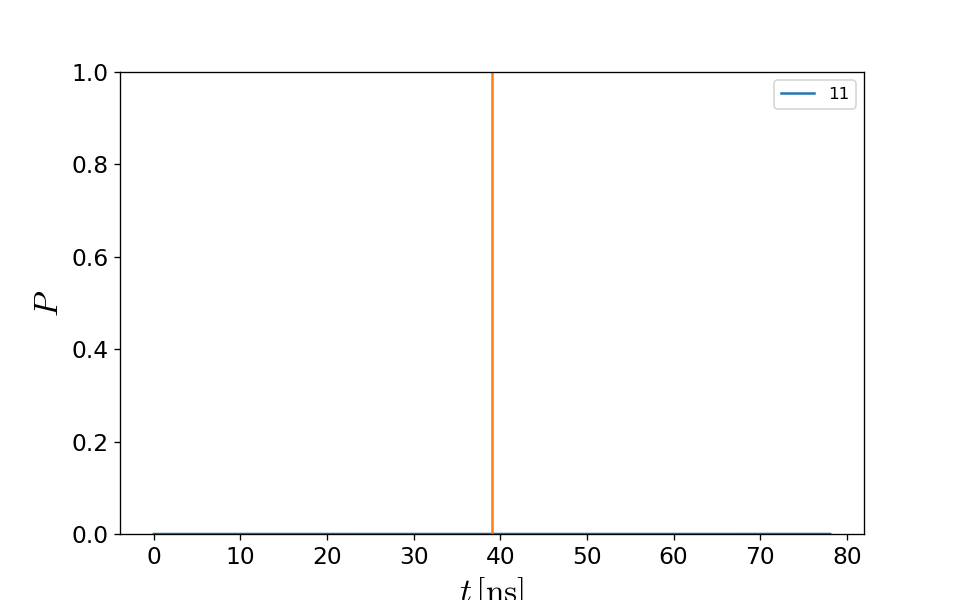

In [159]:
labels = ["00", "01", "10", "11"]
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    for k in range(0, 4):
        plt.figure()
        plt.plot(tlist, probs[k, :], label = labels[k])#, linewidth=opt['lw'], color=cols[k])
        plt.plot([t_drive, t_drive], [0, 1])
        plt.xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
        plt.ylabel('$P$', fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])
        plt.ylim(0, 1.0)
        plt.legend()
        plt.show()

plot_probas(tlist/(2*np.pi), probs, plot_setup)
    

## Phases

In [66]:
#phases : 

phases = np.zeros([4, t_points], dtype=float)
for k in range(0, t_points):
    phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
    phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0]) 
    phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
    phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0]) 

<IPython.core.display.Javascript object>


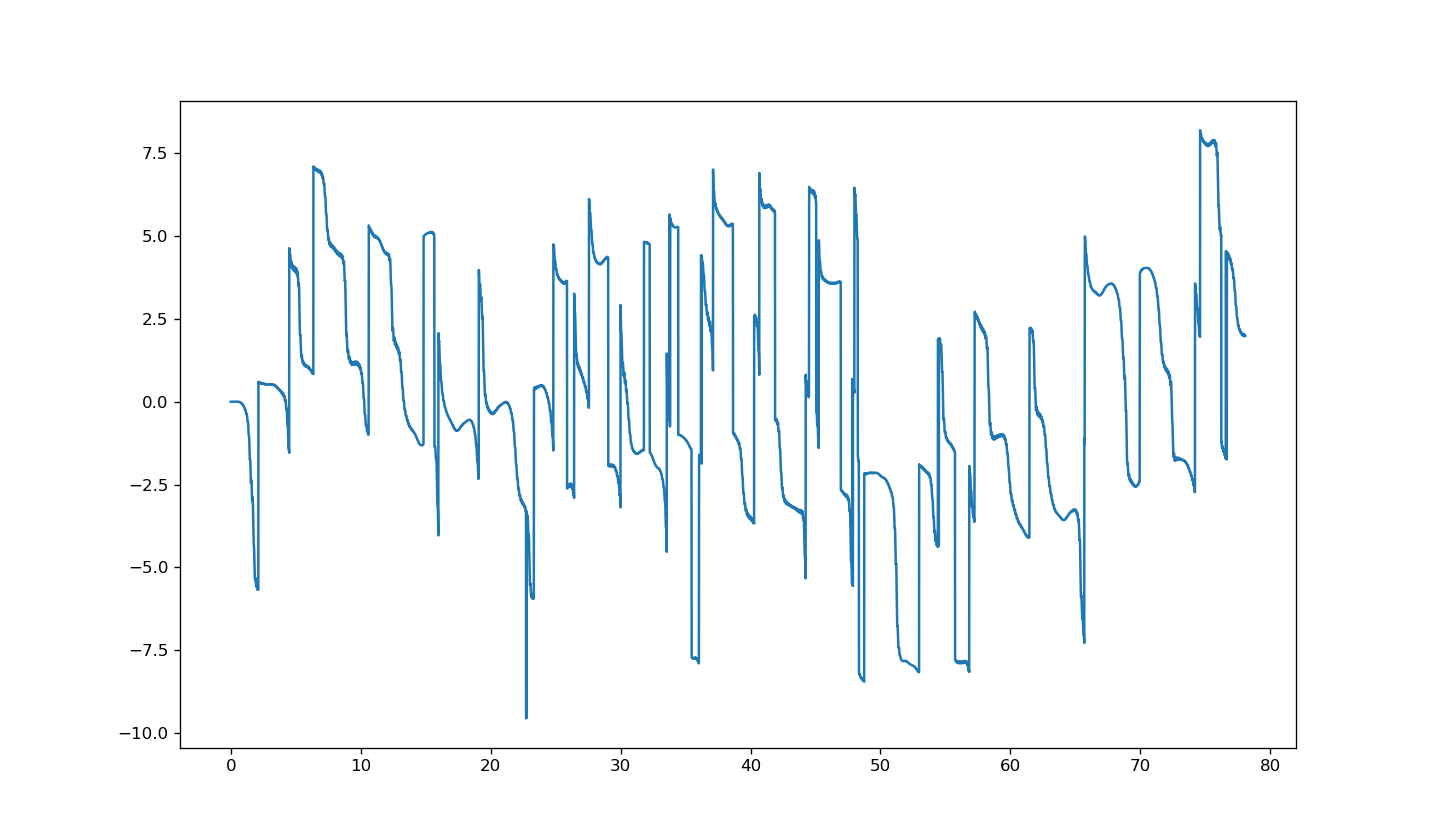

In [157]:
plt.figure(figsize = (12, 7))
plt.plot(tlist/(2*np.pi), (phases[3,:]-phases[0,:]) - (phases[2,:]-phases[0,:]) - (phases[1,:]-phases[0,:]) )

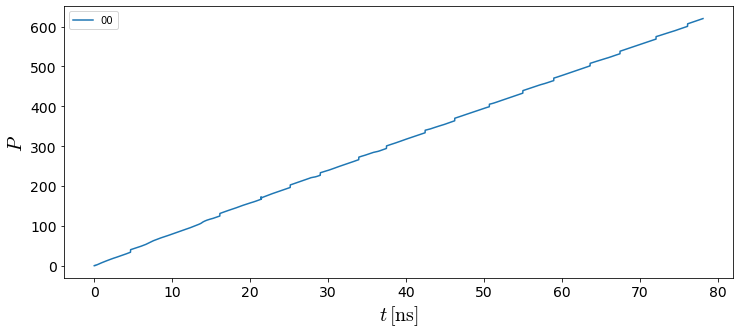

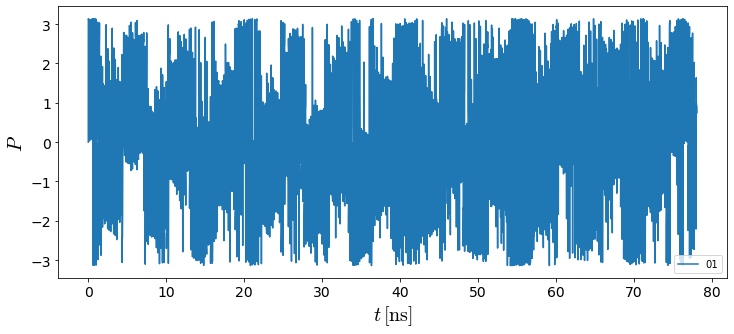

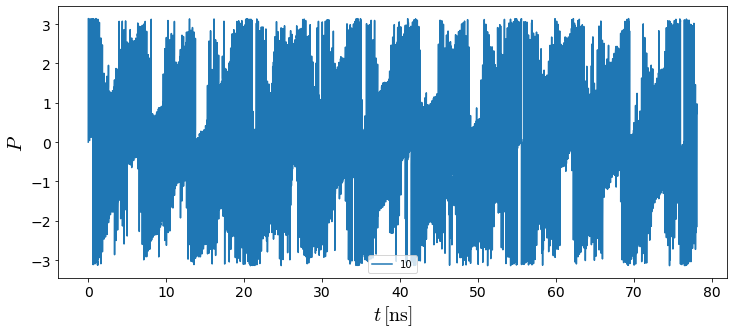

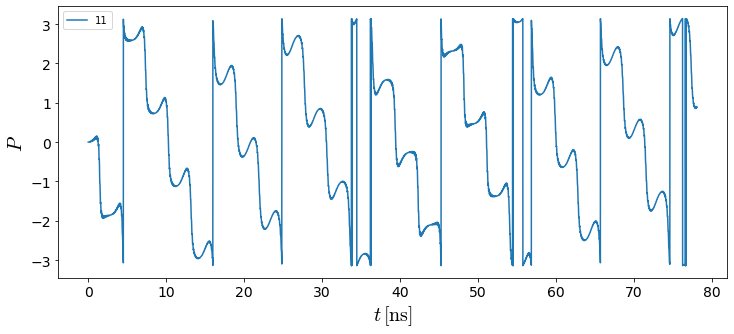

In [131]:
# Plot phases :
labels = ["00", "01", "10", "11"]
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    opt: dict
) -> None:
    cols = ['red', 'green', 'orange', 'blue']
    for k in range(0, 4):
        plt.figure(figsize = (12, 5))
        plt.plot(tlist, phases[k, :], label = labels[k])#, linewidth=opt['lw'], color=cols[k])
        plt.xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
        plt.ylabel('$P$', fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])
#         plt.ylim(0, 1.0)
        plt.legend()
        plt.show()

plot_phases(tlist/(2*np.pi), phases, plot_setup)

## Phases new

In [69]:
phases = np.zeros((4, len(tlist)))

result = solvkit.integrate(tlist, state00, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[0, :] = [cmath.phase((result.states[k].dag() * state00).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state01, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[1, :] = [cmath.phase((result.states[k].dag() * state01).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state10, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[2, :] = [cmath.phase((result.states[k].dag() * state10).full()[0,0]) for k in range(len(tlist))]

result = solvkit.integrate(tlist, state11, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
phases[3, :] = [cmath.phase((result.states[k].dag() * state11).full()[0,0]) for k in range(len(tlist))]

## Leakage

<IPython.core.display.Javascript object>


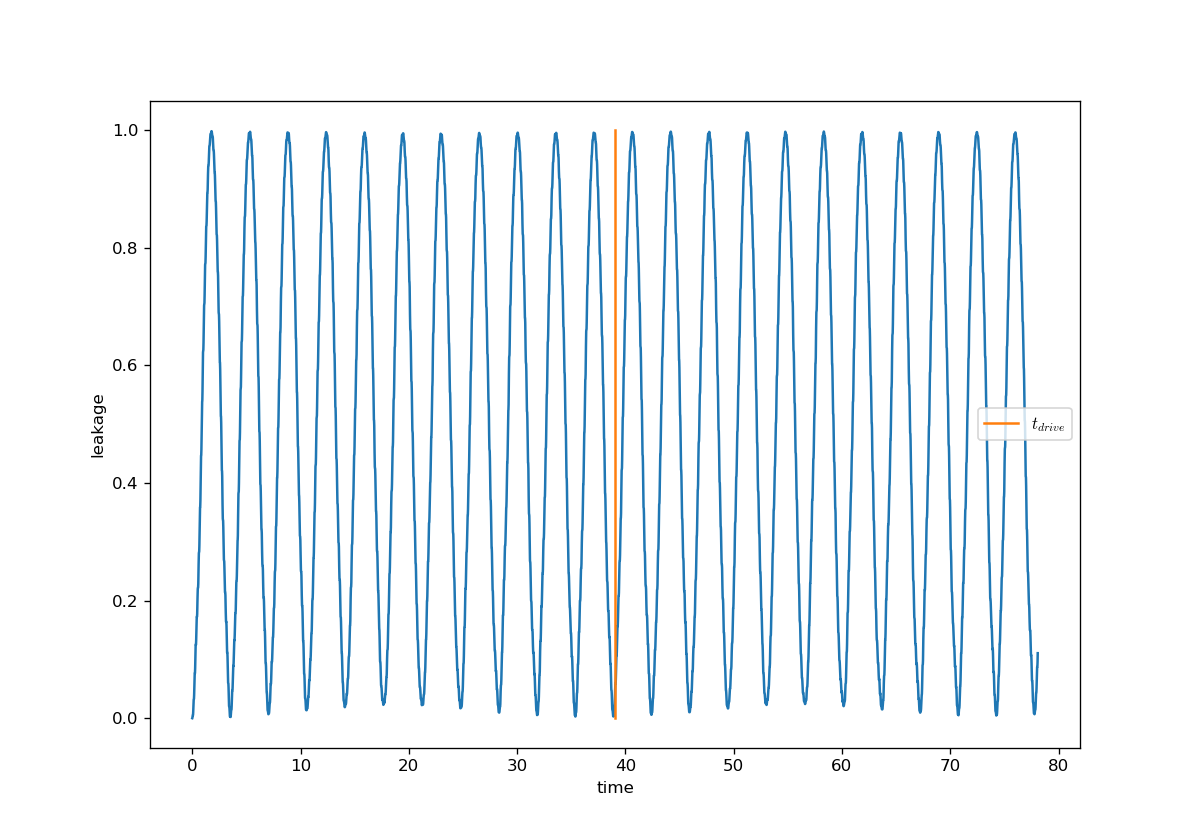

Max leakage over this time period is : 99.83970544949811%


In [155]:
def leakage(state_init, 
            tlist=tlist, hamil0=hamil0, hamil_drive=hamil_drive, pulse_drive=pulse_drive, 
            bool_plot = True):
    result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    
    probs = np.zeros([4, t_points], dtype=float)
    for k in range(0, t_points):
        probs[0, k] = qtp.expect(rho_00, result.states[k]) 
        probs[1, k] = qtp.expect(rho_01, result.states[k]) 
        probs[2, k] = qtp.expect(rho_10, result.states[k]) 
        probs[3, k] = qtp.expect(rho_11, result.states[k]) 
    
    leakage = [1-sum(probs[:,j]) for j in range(len(tlist))]
    if bool_plot:
        plt.figure()
        plt.plot(tlist/(2*np.pi), leakage)
        plt.plot([t_drive, t_drive], [0, 1], label = "$t_{drive}$")
        plt.xlabel('time')
        plt.ylabel('leakage')
        plt.legend()
        
    
    print("Max leakage over this time period is : "+ str(np.max(leakage)*100) + "%")
    
state_init = state10#state00 + state_01 + state_10 + state_11
leakage(state_init)

In [153]:
print("\nFor only state00:")
leakage(state00, bool_plot = False)

print("\nFor only state01:")
leakage(state01, bool_plot = False)

print("\nFor only state10:")
leakage(state10, bool_plot = False)

print("\nFor only state11:")
leakage(state11, bool_plot = False)


For only state00:
Max leakage over this time period is : 12.016236223388177%

For only state01:
Max leakage over this time period is : 54.836187742319765%

For only state10:
Max leakage over this time period is : 99.83970544949811%

For only state11:
Max leakage over this time period is : 99.39169018729773%


# Tomography

In [ ]:
def gate_function(state_in, **kwargs):
    t_points = kwargs['t_points']
    tlist = np.linspace(0, kwargs['t_max'], t_points)
    rho_in = state_in*state_in.dag()
    hamil0 = kwargs['hamil0']
    hamil_drive = kwargs['hamil_drive']
                                  
    pulse_drive = np.cos(kwargs['freq_drive']*tlist)

    result = solvkit.integrate(tlist, state_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

    end_state = result.states[-1]
    return end_state

In [ ]:
param_dict = {
    't_points' : 10000 ,
    't_max' : t_drive,
    'hamil0' : coupled_flx.hamiltonian(as_qobj=True),
    'hamil_drive' : qtp.Qobj(inpt=eta[0]*n_charge[0] + eta[1]*n_charge[1], 
                       dims=hamil0.dims, shape=hamil0.shape, isherm=True),
    'freq_drive' : freq_drive
}

In [22]:
import pysqkit.tomography.utilsTomo as tomo

In [23]:
fct = tomo.rid_of_dict(gate_function,param_dict)
nb_levels = [3,3]

c:\users\nicol\git\qutech 2021\pysqkit\pysqkit\tomography\utilsTomo.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


It took 142.28366661071777 seconds


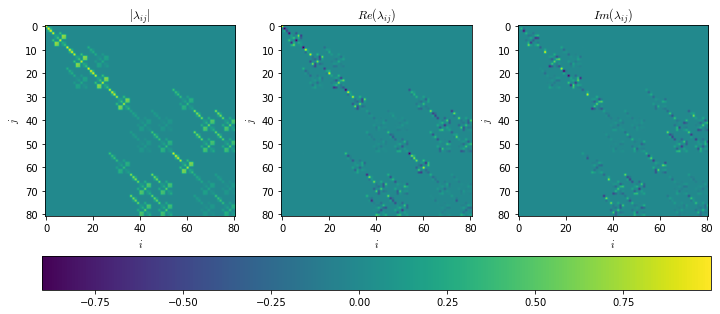

In [24]:
deb =  time.time()
lambda_mat = tomo.fct_to_lambda(fct, nb_levels, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

It took 17.433242321014404 seconds


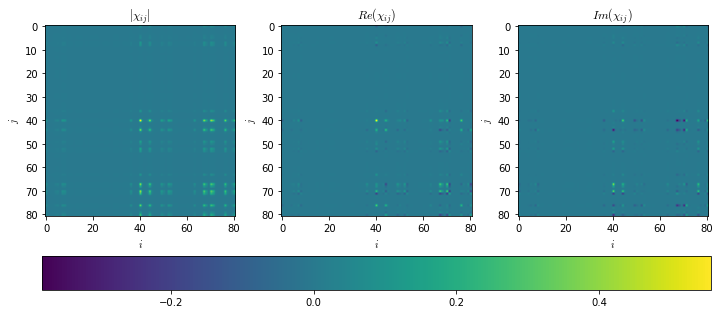

In [25]:
deb =  time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [29]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

c:\users\nicol\git\qutech 2021\pysqkit\pysqkit\tomography\utilsTomo.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


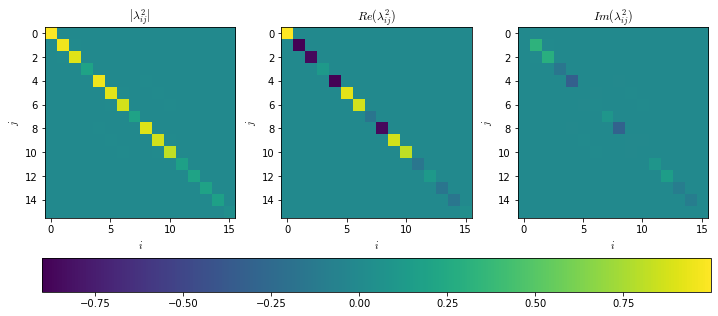

In [32]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

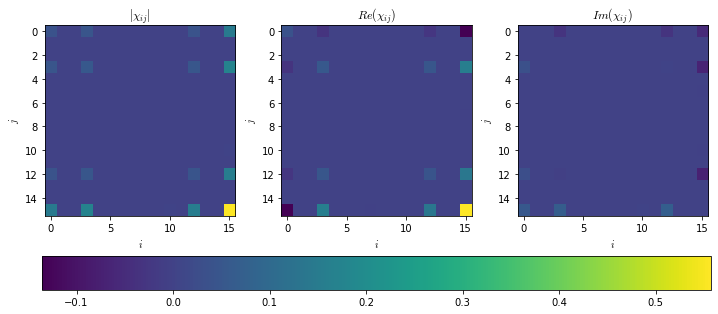

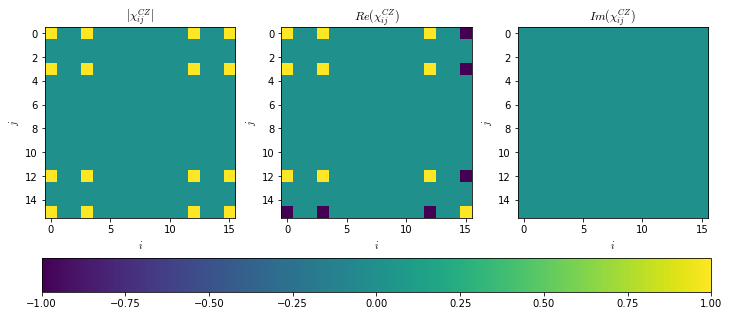

In [75]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")